[INFO] Loading data...
[INFO] Preprocessing data...
[INFO] Data cleaned and saved to heart_disease_clean.csv
[INFO] Building Bayesian Network model...
[INFO] Model built and inference engine initialized.

[STRUCTURE] Model Edges:
  age_cat → fbs
  fbs → target
  target → chol_cat
  target → thalach_cat
[INFO] Visualizing Bayesian Network...


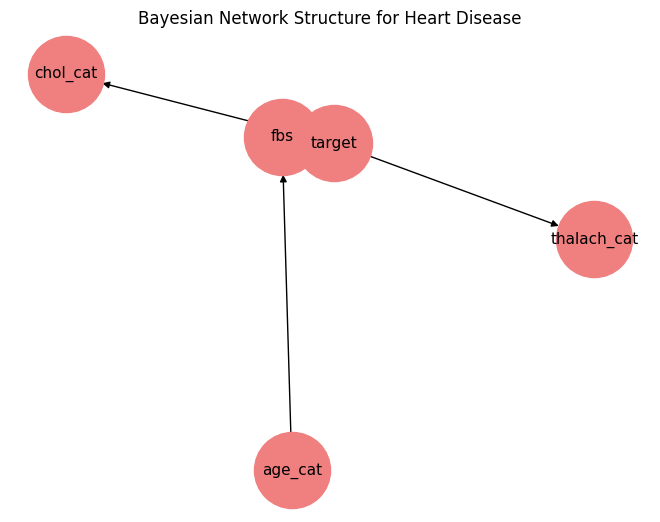

[INFO] Saved network visualization as bayesian_network_structure.png
[INFO] Running inference examples...

[QUERY] P(target | chol_cat = high)
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.0000 |
+-----------+---------------+
| target(1) |        1.0000 |
+-----------+---------------+


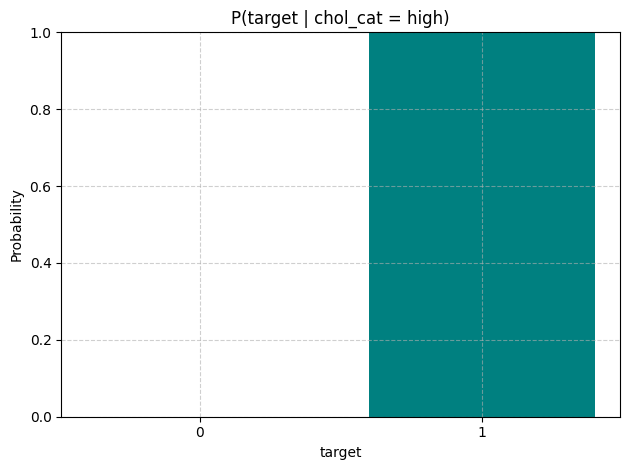


[QUERY] P(chol_cat | target = 1)
+------------------+-----------------+
| chol_cat         |   phi(chol_cat) |
+==================+=================+
| chol_cat(high)   |          0.0122 |
+------------------+-----------------+
| chol_cat(low)    |          0.7805 |
+------------------+-----------------+
| chol_cat(medium) |          0.2073 |
+------------------+-----------------+


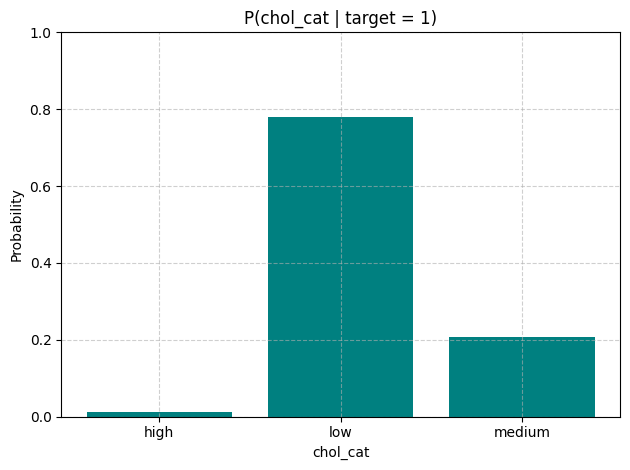


[QUERY] P(target | age_cat=young, fbs=0)
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.4514 |
+-----------+---------------+
| target(1) |        0.5486 |
+-----------+---------------+


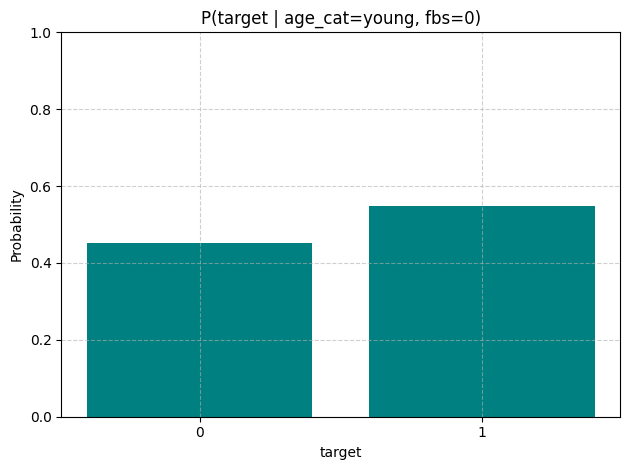


[QUERY] P(thalach_cat | target = 1)
+---------------------+--------------------+
| thalach_cat         |   phi(thalach_cat) |
+=====================+====================+
| thalach_cat(high)   |             0.5793 |
+---------------------+--------------------+
| thalach_cat(low)    |             0.0244 |
+---------------------+--------------------+
| thalach_cat(medium) |             0.3963 |
+---------------------+--------------------+


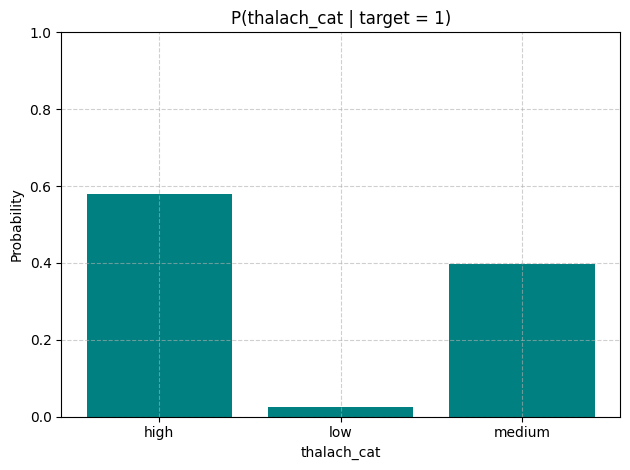


[QUERY] P(target | age_cat=old, fbs=1)
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.4889 |
+-----------+---------------+
| target(1) |        0.5111 |
+-----------+---------------+


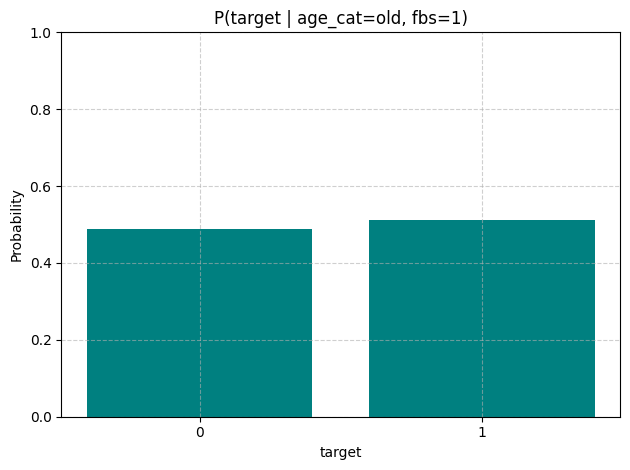


[INFO] Total execution time: 1.14 seconds


In [16]:
import pandas as pd
import time
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler


class HeartDiseaseBayesianNetwork:
    def __init__(self):
        self.data = None
        self.cleaned_data = None
        self.model = None
        self.infer = None

    def load_data(self, file_path):
        print("[INFO] Loading data...")
        self.data = pd.read_csv(file_path)

    def preprocess_data(self):
        print("[INFO] Preprocessing data...")

        self.cleaned_data = self.data.drop_duplicates().dropna()

        # Min-Max normalize numeric columns
        numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
        scaler = MinMaxScaler()
        self.cleaned_data[numeric_cols] = scaler.fit_transform(self.cleaned_data[numeric_cols])

        # Discretize into categories
        self.cleaned_data['chol_cat'] = pd.cut(
            self.cleaned_data['chol'], [-1, 0.33, 0.66, 1.0], labels=['low', 'medium', 'high']
        )
        self.cleaned_data['thalach_cat'] = pd.cut(
            self.cleaned_data['thalach'], [-1, 0.33, 0.66, 1.0], labels=['low', 'medium', 'high']
        )
        self.cleaned_data['age_cat'] = pd.cut(
            self.cleaned_data['age'], [-1, 0.33, 0.66, 1.0], labels=['young', 'middle-aged', 'old']
        )

        self.cleaned_data['fbs'] = self.cleaned_data['fbs'].astype(str)
        self.cleaned_data['target'] = self.cleaned_data['target'].astype(str)

        self.cleaned_data.to_csv("heart_disease_clean.csv", index=False)
        print("[INFO] Data cleaned and saved to heart_disease_clean.csv")

    def build_model(self):
        print("[INFO] Building Bayesian Network model...")

        self.model = DiscreteBayesianNetwork([
            ('age_cat', 'fbs'),
            ('fbs', 'target'),
            ('target', 'chol_cat'),
            ('target', 'thalach_cat')
        ])

        self.model.fit(
            self.cleaned_data[['age_cat', 'fbs', 'target', 'chol_cat', 'thalach_cat']],
            estimator=MaximumLikelihoodEstimator
        )

        self.infer = VariableElimination(self.model)
        print("[INFO] Model built and inference engine initialized.")

        print("\n[STRUCTURE] Model Edges:")
        for edge in self.model.edges():
            print(f"  {edge[0]} → {edge[1]}")

    def visualize_network(self):
        print("[INFO] Visualizing Bayesian Network...")

        graph = nx.DiGraph()
        graph.add_nodes_from(self.model.nodes())
        graph.add_edges_from(self.model.edges())

        pos = nx.spring_layout(graph, seed=42)
        nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='lightcoral', font_size=11, arrows=True)
        plt.title("Bayesian Network Structure for Heart Disease")
        plt.savefig("bayesian_network_structure.png")
        plt.show()

        print("[INFO] Saved network visualization as bayesian_network_structure.png")

    def visualize_query_result(self, result, title):
        labels = result.state_names[result.variables[0]]
        values = result.values

        plt.bar(labels, values, color='teal')
        plt.title(title)
        plt.xlabel(result.variables[0])
        plt.ylabel('Probability')
        plt.ylim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    def run_inference_examples(self):
        print("[INFO] Running inference examples...")

        def query_and_plot(variables, evidence, description):
            result = self.infer.query(variables=variables, evidence=evidence, show_progress=False)
            print(f"\n[QUERY] {description}")
            print(result)
            self.visualize_query_result(result, description)

        query_and_plot(['target'], {'chol_cat': 'high'}, "P(target | chol_cat = high)")
        query_and_plot(['chol_cat'], {'target': '1'}, "P(chol_cat | target = 1)")
        query_and_plot(['target'], {'age_cat': 'young', 'fbs': '0'}, "P(target | age_cat=young, fbs=0)")
        query_and_plot(['thalach_cat'], {'target': '1'}, "P(thalach_cat | target = 1)")
        query_and_plot(['target'], {'age_cat': 'old', 'fbs': '1'}, "P(target | age_cat=old, fbs=1)")


# === RUN THE PIPELINE ===
if __name__ == "__main__":
    start = time.time()
    bn = HeartDiseaseBayesianNetwork()
    bn.load_data("/content/heart_disease.csv")
    bn.preprocess_data()
    bn.build_model()
    bn.visualize_network()
    bn.run_inference_examples()
    print(f"\n[INFO] Total execution time: {time.time() - start:.2f} seconds")